In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropy.stats
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
import astropy.io.fits as fits
from astropy.modeling import models, fitting
from scipy.signal import medfilt
import scipy
from lmfit.models import GaussianModel, SkewedGaussianModel
import matplotlib.lines as mlines

import os, shutil
import itertools as it

from palettable.tableau import Tableau_10
col = Tableau_10.hex_colors

from binotools import calbino
import binotools as bt

plt.style.use('seaborn-talk')
from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

plt.rc('figure', dpi=150, figsize=(5,5))

In [2]:
# Find the stars
slits = pd.read_csv(os.environ['BINO_DIR']+'2649_BLAS_1/masks/BLAS_1_slits.csv')

# fits file ext # = slits.index + 1
slits['extnum'] = slits.index + 1

stars = slits[slits.type == 'STANDARD']
stars

,slit,targetnum,name,ra,dec,pmra,pmdec,mag,priority,epoch,type,wave_start,wave_end,side,extnum
19,255,1916,f_3,188.910191,62.352588,0,0,0.001,1,2000,STANDARD,6855.558347,9378.533932,A,20
20,254,1915,f_2,188.902346,62.363999,0,0,0.001,1,2000,STANDARD,6773.112436,9296.124509,A,21


# Get data

In [3]:
# datadir = os.environ['BINO_DIR']+'2649_BLAS_1/reduced_data/2019.0423_red_seeing1.2_6.25hrs/'
datadir = os.environ['BINO_DIR']+'SAO-9/'
os.listdir(datadir)

# spec1D_all = sorted(bt.insensitive_glob(datadir+'/*/reduced/*/obj_abs_slits_extr.fits'))
spec2D_all = sorted(bt.insensitive_glob(datadir+'/*/reduced/*/obj_clean*abs_slits_lin.fits'))

spec2D_all

nights = np.array([s.split('reduced/')[-1].split('/')[0] for s in spec2D_all])
nights = np.unique(nights)
nights

array(['2019.0208', '2019.0212', '2019.0329', '2019.0331', '2019.0404'],
      dtype='<U9')

In [9]:
# # 1D slit spectra
extract2D  = fits.open(spec2D_all[0])

spec2D = extract2D[1].data
# err1D  = extract1D['ERROR'].data

# # Get wavelength vector
header  = extract2D[1].header
nstep   = spec2D.shape[1]
print(nstep)
wave_nm = header['CRVAL1'] + np.linspace(0., nstep*header['CDELT1'], nstep)
wave_A  = wave_nm * 10.

5632


# Get star spectra

## Telluric corrections

In [22]:
telluric_regions = {'O2 A band':[757., 775.],
                    'O2 B-band':[685., 694.]}

mask_telluric = np.array([], dtype=int)
for region in telluric_regions:
    mask_telluric = np.hstack((mask_telluric, (np.where((wave_nm > telluric_regions[region][0]) & (wave_nm < telluric_regions[region][1]))[0])))

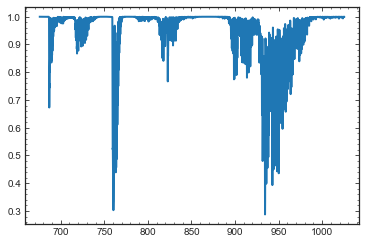

In [23]:
calib_dir = os.environ['BINO_DIR']+'2649_BLAS_1/calib/'
trans = np.genfromtxt(calib_dir+'BLAS_2019A_transmission.txt', names=True)

plt.plot(trans['wave_nm'], trans['transmission'])


In [24]:
def std_telluric_region(args, opt_args):
    """RMS of corrected flux in region of O2 A-band"""
    
    alpha, beta = args    
    wave, flux_in, trans_std = opt_args
    
    flux_corr = telluric_correction(wave, flux_in, trans_std, alpha, beta)
    
    return np.nanstd(flux_corr[mask_telluric])

def telluric_correction(wave, flux_in, trans_std, alpha=0., beta=1.):
    """
    Telluric correction (assuming std at same airmass as target)
    
    F_corr = F_in / T(lambda - alpha)**beta
    """
    
    # Translate and scale transmission
    transmission_function = np.interp(wave-alpha, wave, trans_std)**beta
    
    flux_out = flux_in/transmission_function
    flux_out[flux_out == 0.] = np.nan
    
    return flux_out

def optimized_tellcorr(wave, flux_in, trans_std, verbose=False):
    initial_guess = [0, 1.]  # initial guess can be anything
    result = scipy.optimize.minimize(std_telluric_region, initial_guess, 
                                     args=[wave, flux_in, trans_std])
    if verbose:
        print(result.x)
    return telluric_correction(wave, flux_in, trans_std, alpha=result.x[0], beta=result.x[1])

In [5]:
def extract1D(spec2D, psf_lim=0.01, plot=False, ax=None):
    """
    Extract 1D spectrum from 2D using PSF
    """
    
    # Get psf for extraction
    psf  = np.nansum(spec2D_star, axis=1)
    psf -= psf.min()
    psf /= psf.sum()    
    psf_range = np.where(psf > psf_lim*psf.max())[0]
    
    if plot:
        ax.plot(psf, lw=1, alpha=0.7)
        ax.axvline(psf_range[0], ls='dashed', lw=0.5, c='k')
        ax.axvline(psf_range[-1], ls='dashed', lw=0.5, c='k')        
    
    return np.nansum(spec2D_star[psf_range], axis=0)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


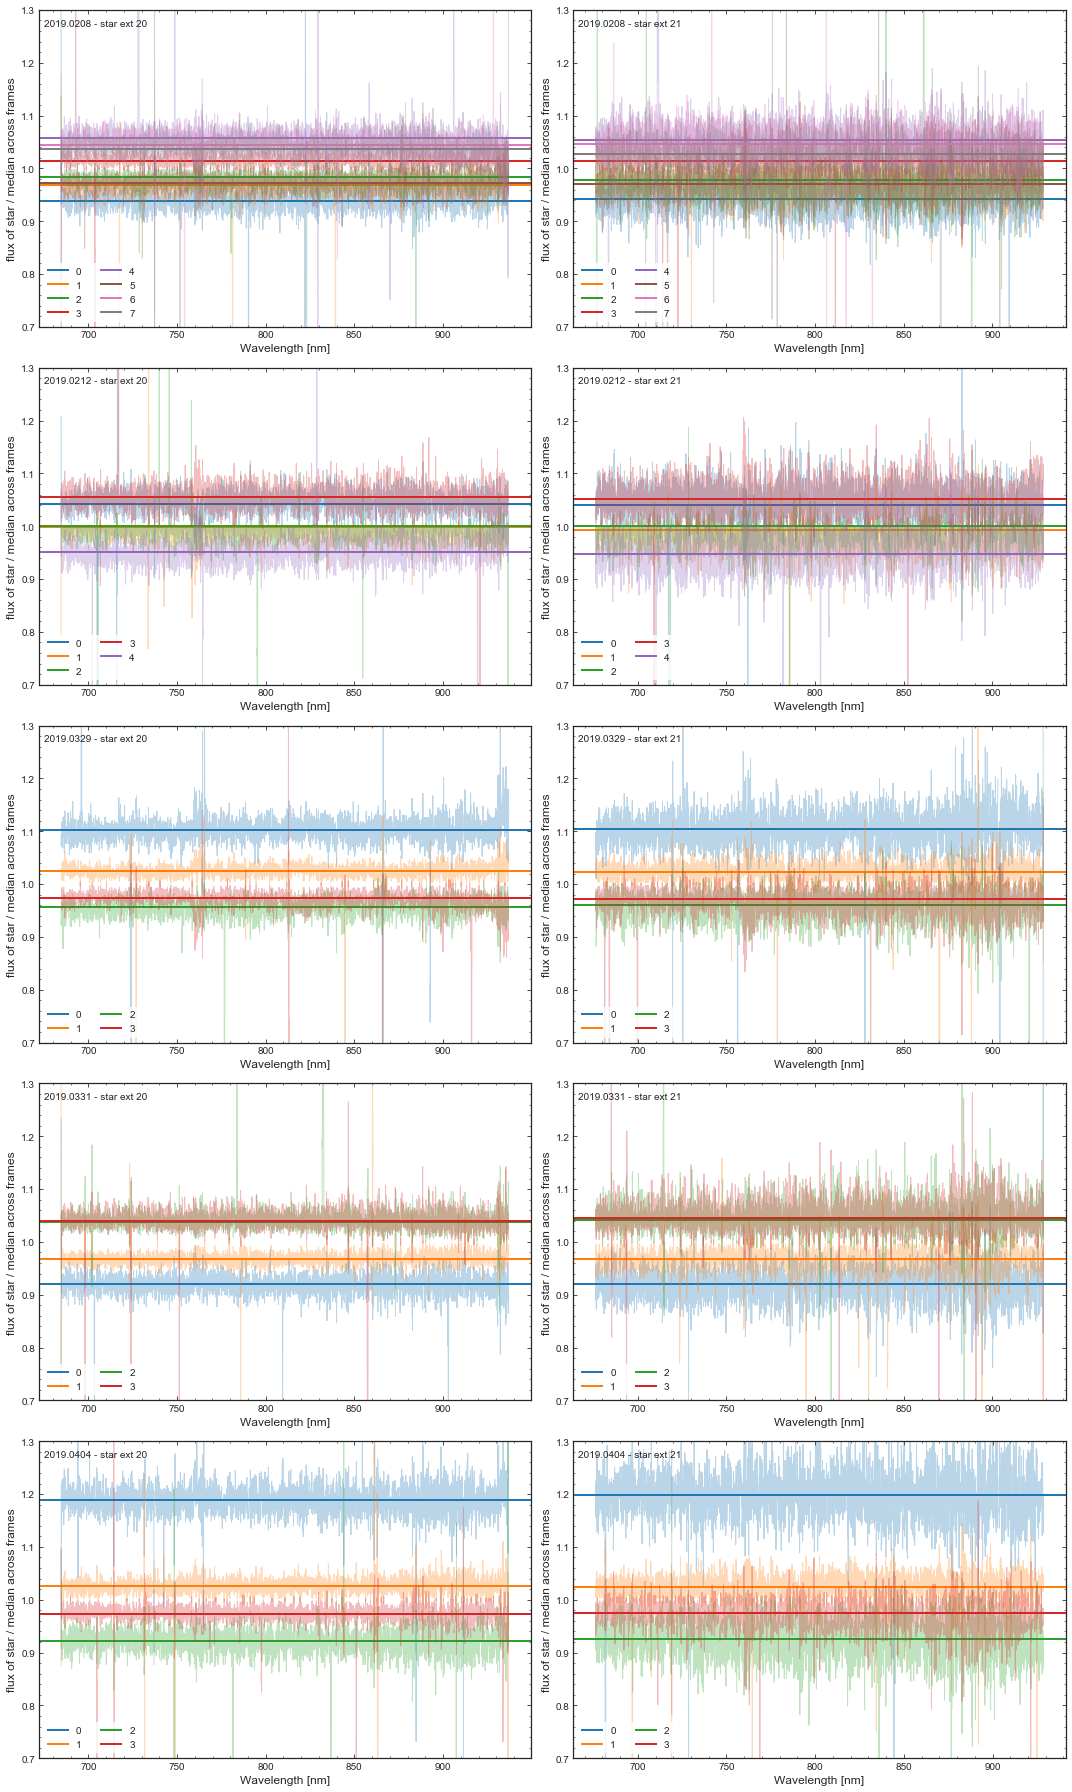

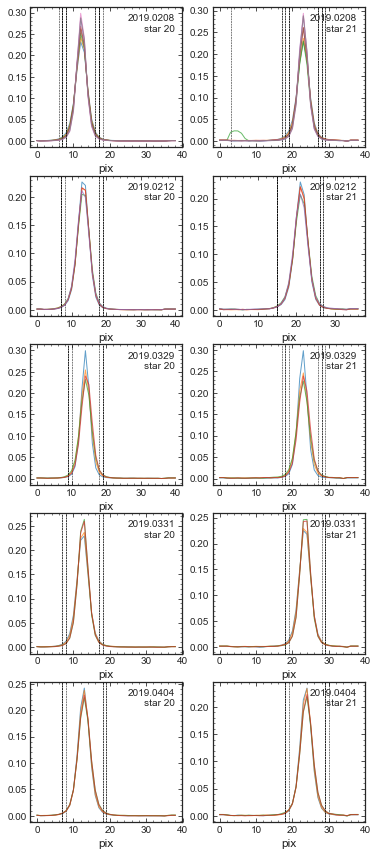

In [6]:
tell_corr = True

fig, ax = plt.subplots(len(nights),len(stars), figsize=(15,5*len(nights)), dpi=72)
ax = ax.ravel()

fig_psf, ax_psf = plt.subplots(len(nights),len(stars), figsize=(6,3*len(nights)), dpi=72)
ax_psf = ax_psf.ravel()

for i, (n, j) in enumerate(it.product(nights, range(2))):
    
    spec2D_n = sorted(bt.insensitive_glob(datadir+'/*/reduced/%s/obj_clean*abs_slits_lin.fits' % n))
    
    # Get 1D spectra
    spec1D_eachframe = np.zeros((len(spec2D_n),len(wave_nm)))
    for ss, spec2D_file in enumerate(spec2D_n):
    
        spec2D_hdu  = fits.open(spec2D_file)
        spec2D_star = spec2D_hdu[stars.index[j]+1].data
        
        spec1D_eachframe[ss] = extract1D(spec2D_star, psf_lim=0.02, plot=True, ax=ax_psf[i])
        
    # Divide by median
    spec1D_med = np.nanmedian(spec1D_eachframe, axis=0)     
    for ss, spec2D_file in enumerate(spec2D_n):
        
        frame = spec2D_file.split('clean')[-1].split('_')[0]
        ln = ax[i].plot(wave_nm, spec1D_eachframe[ss]/spec1D_med, lw=1, alpha=0.3)#, label='%s' % frame[-1])
        ax[i].axhline(np.nanmedian(spec1D_eachframe[ss]/spec1D_med), c=ln[0].get_color(), lw=2, alpha=1, label='%s' % frame[-1])

#     med_scale = np.nanmedian(spec1D_eachframe/spec1D_med, axis=1)
#     print(sorted(med_scale))
#     print(np.std(med_scale))

    ax_psf[i].annotate('%s\nstar %i' % (n, stars.index[j]+1), xy=(0.95,0.95), xycoords='axes fraction', va='top', ha='right')
    ax_psf[i].set_xlabel('pix')
    
    ax[i].set_ylim(0.7, 1.3)
    ax[i].annotate('%s - star ext %i' % (n, stars.index[j]+1), xy=(0.01,0.95), xycoords='axes fraction')
    ax[i].legend(loc='lower left', ncol=2, frameon=True)
    ax[i].set_xlabel('Wavelength [nm]')
    ax[i].set_ylabel('flux of star / median across frames')

fig.tight_layout()
fig.savefig('2019A_fluxratio_eachframe.png', bbox_inches='tight')

# fig_psf.tight_layout()
fig_psf.savefig('2019A_psf_eachframe.pdf', bbox_inches='tight')

# Flux Calibration

In [7]:
# Init flux cal
fluxcal = calbino.FluxCalBino()

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


(5632, 8)
(5632, 5)
(5632, 4)


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


(5632, 4)
(5632, 4)


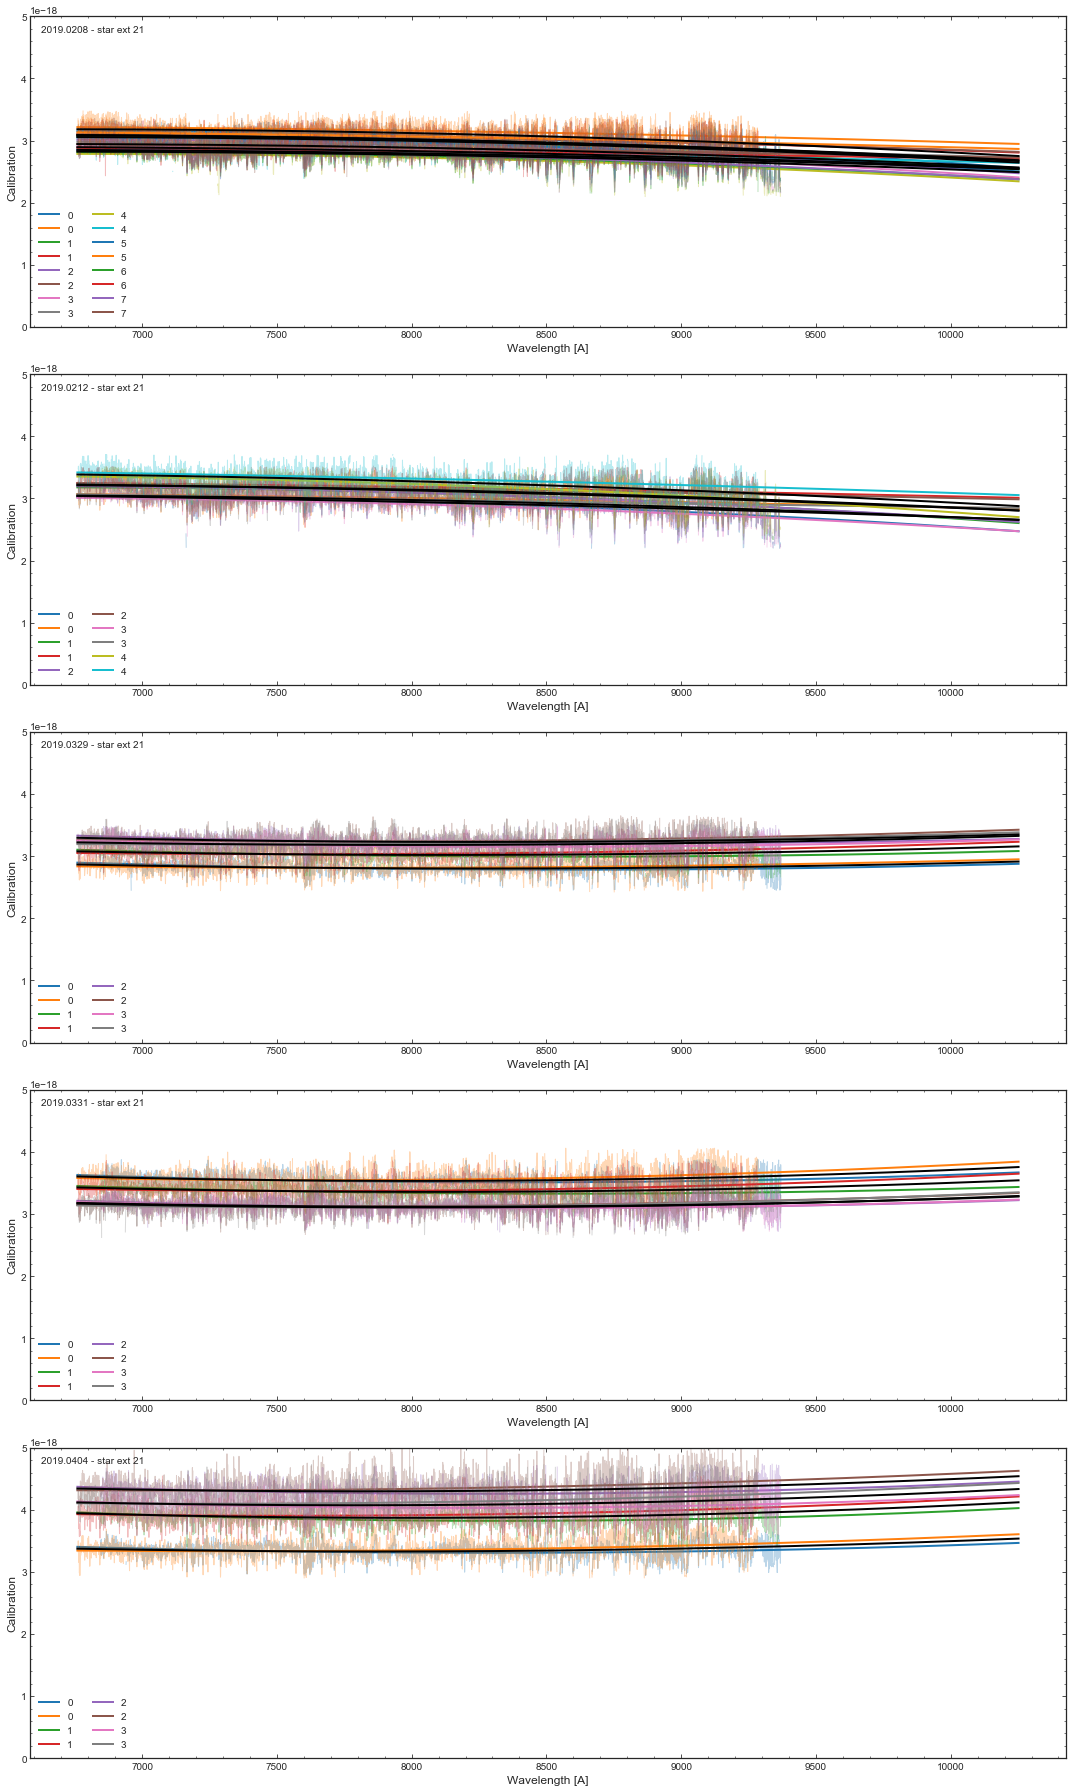

In [59]:
tell_corr =True

# Flux calibration
fig, ax = plt.subplots(len(nights), 1, figsize=(15,5*len(nights)), dpi=72)
ax = ax.ravel()

# smoothcalib_both_stars = np.zeros((len(wave_nm),len(total_frames)))
for i, n in enumerate(nights):
    
    spec2D_n = sorted(bt.insensitive_glob(datadir+'/*/reduced/%s/obj_clean*abs_slits_lin.fits' % n))
    err2D_n  = sorted(bt.insensitive_glob(datadir+'/*/reduced/%s/obj_clean*abs_err_slits_lin.fits' % n))
    
    # Get 1D spectra for each frame
    spec1D_eachframe = np.zeros((len(spec2D_n),len(wave_nm)))
    
    calib_frame_both_stars = np.zeros((len(wave_nm),len(spec2D_n),2))

    for ss, spec2D_file in enumerate(spec2D_n):
                
        # For each star
        for j in range(2):
            # Load star mags from SDSS
            ra, dec = stars.iloc[j].ra, stars.iloc[j].dec
            fluxcal.get_star_mags(ra, dec, verbose=False)

            star_mags = fluxcal.star_mags
           
            spec2D_hdu  = fits.open(spec2D_file)
            spec2D_star = spec2D_hdu[stars.index[j]+1].data

            spec1D_mask = extract1D(spec2D_star, psf_lim=0.02, plot=True, ax=ax_psf[i])

            if tell_corr:
                # Do telluric correction
                spec1D_eachframe[ss] = optimized_tellcorr(wave_nm, spec1D_mask, trans['transmission'])
            else:
                # Mask bad telluric
                spec1D_eachframe[ss][mask_telluric] = np.nan

            calibration = fluxcal.flux_calibration(spec1D_eachframe[ss], wave_A)
    #     calibration_both.append(calibration)

    #         smoothed_calibration = fluxcal.smooth_calibration(wave_A, calibration, polyfit=False)

            # block bad calib
            cut = 98.
            low, high = np.nanpercentile(calibration, 100-cut), np.nanpercentile(calibration, cut)
            calibration[np.where((calibration < low) | (calibration > high))] = np.nan
            polyfitted_calibration = fluxcal.smooth_calibration(wave_A, calibration, degree=2)

            frame = spec2D_file.split('clean')[-1].split('_')[0]
            ln = ax[i].plot(wave_A, calibration, lw=1, alpha=0.3)
            ax[i].plot(wave_A, polyfitted_calibration, c=ln[0].get_color(), lw=2, alpha=1, label='%s' % frame[-1])
            
            calib_frame_both_stars[:,ss,j] = polyfitted_calibration
            
    calib_frame_both_stars_med = np.median(calib_frame_both_stars, axis=2)
    print(calib_frame_both_stars_med.shape)   
    ax[i].plot(wave_A, calib_frame_both_stars_med, c='k')

#     med_scale = np.nanmedian(spec1D_eachframe/spec1D_med, axis=1)
#     print(sorted(med_scale))
#     print(np.std(med_scale))

    ax[i].set_ylim(0., 5e-18)

    ax[i].annotate('%s - star ext %i' % (n, stars.index[j]+1), xy=(0.01,0.95), xycoords='axes fraction')
    ax[i].legend(loc='lower left', ncol=2, frameon=True)
    ax[i].set_xlabel('Wavelength [A]')
    ax[i].set_ylabel('Calibration')
    
    #######################################333
    # Do flux calibration
    for ss in range(len(spec2D_n)):
        
        spec_filename_unfluxed = [spec2D_n[ss], err2D_n[ss]]
        for sss, spec_filename in enumerate(spec_filename_unfluxed):
            
            hdulist = fits.open(spec_filename)
    
            for slit in hdulist:
                dat2D = slit.data

                if type(dat2D) == np.ndarray:

                    if sss == 0:
                        # Do transmission correction
                        dat2D /= trans['transmission']
                        dat2D[dat2D == 0.] = np.nan
                        slit.header['TELLCORR'] = 'Using %s' % ('BLAS_2019A_transmission.txt')

                    # Do flux calib
                    slit.data = dat2D * calib_frame_both_stars_med[:,ss]

                    slit.header['FLUXCAL'] = 'flux calibration'

            spec_filename_fluxcalib = spec_filename.replace('.fits', '_fluxcalib.fits')
            hdulist.writeto(spec_filename_fluxcalib, overwrite=True)

fig.tight_layout()
fig.savefig('2019A_calibration_eachframe.png', bbox_inches='tight')

# fig_psf.tight_layout()

In [17]:
import datetime
now = datetime.datetime.now()
now.strftime('%Y-%m-%d')

'2019-11-05'

In [72]:
frame_list = np.genfromtxt('/h/hobnob0/Binospec/SAO-9/flux_calib_frames_data_191008.txt', dtype='U100')
errframe_list = np.genfromtxt('/h/hobnob0/Binospec/SAO-9/flux_calib_frames_err_191008.txt', dtype='U100')

inpdir = ['/h/hobnob0/Binospec/SAO-9/'+frame_path.split('obj_')[0] for frame_path in frame_list]
print(inpdir)

fdata = ['obj_'+frame_path.split('obj_')[-1] for frame_path in frame_list]
print('\n', fdata)

efdata = ['obj_'+frame_path.split('obj_')[-1] for frame_path in errframe_list]
print('\n', efdata)

['/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0212/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0212/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0212/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0212/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0212/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0329/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0329/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0329/', '/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0329/', '/h/hobnob0/Binospec/SAO-9/BLAS_1b/reduced/2019